In [104]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from collections import Counter

from conformal_utils import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
logits = torch.load('data/imagenet_val/logits.pt')
labels = torch.load('data/imagenet_val/labels.pt')

# Convert to Numpy arrays
logits = logits.numpy()
labels = labels.type(torch.LongTensor).numpy()

### Some sanity checks

In [5]:
logits.shape

torch.Size([50000, 1000])

In [6]:
labels.shape

torch.Size([50000])

In [19]:
min(labels), max(labels)

(tensor(0.), tensor(999.))

In [17]:
# Check that there are 50 instances of each class
Counter(labels.numpy())

Counter({828.0: 50,
         800.0: 50,
         998.0: 50,
         782.0: 50,
         570.0: 50,
         900.0: 50,
         164.0: 50,
         776.0: 50,
         303.0: 50,
         967.0: 50,
         81.0: 50,
         779.0: 50,
         520.0: 50,
         441.0: 50,
         563.0: 50,
         849.0: 50,
         197.0: 50,
         885.0: 50,
         275.0: 50,
         615.0: 50,
         265.0: 50,
         196.0: 50,
         826.0: 50,
         464.0: 50,
         569.0: 50,
         131.0: 50,
         618.0: 50,
         969.0: 50,
         578.0: 50,
         507.0: 50,
         624.0: 50,
         510.0: 50,
         427.0: 50,
         997.0: 50,
         455.0: 50,
         2.0: 50,
         841.0: 50,
         866.0: 50,
         633.0: 50,
         973.0: 50,
         18.0: 50,
         613.0: 50,
         953.0: 50,
         202.0: 50,
         126.0: 50,
         596.0: 50,
         774.0: 50,
         302.0: 50,
         812.0: 50,
         96.0: 50,
     

# Exploratory analysis

Use 5,000 instances as calibration and the remaining 45,000 as validation

1. Perform standard conformal inference and evaluate coverage
2. Perform class-balanced conformal inference and evaluate coverage


In [128]:
alpha = .05

In [147]:
np.random.seed(0)

# ======== SHUFFLE AND SPLIT DATA ======== 
split = 40000
idx = np.random.permutation(np.arange(len(labels)))
shuffled_logits = logits[idx]
shuffled_labels = labels[idx]
calib_logits, calib_labels = logits[:split], labels[:split]
val_logits, val_labels = logits[split:], labels[split:]

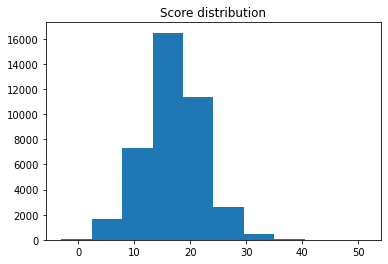

qhat: 8.235639050769802
Standard conformal inference "marginal coverage": 94.95%


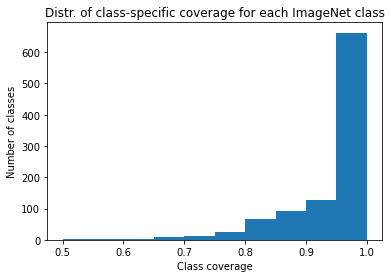

In [148]:
# ======== STANDARD CONFORMAL INFERENCE ======== 
# --- Get confidence sets ---
standard_ci_qhat = compute_qhat(calib_logits, calib_labels, alpha=alpha, plot_scores=True)
print('qhat:', standard_ci_qhat)
standard_ci_preds = create_prediction_sets(val_logits, standard_ci_qhat)

# --- Evaluate confidence sets ---
# i) Marginal coverage
marginal_cov = compute_coverage(val_labels, standard_ci_preds)
print(f'Standard conformal inference "marginal coverage": {marginal_cov*100:.2f}%')
# ii) Class-specific coverage
class_specific_cov = compute_class_specific_coverage(val_labels, standard_ci_preds)
# print(f'Standard conformal inference "class specific coverage": {class_specific_cov}')
plt.hist(class_specific_cov)
plt.xlabel('Class coverage')
plt.ylabel('Number of classes')
plt.title('Distr. of class-specific coverage for each ImageNet class')
plt.show()

One problem I am running into is that the calibration dataset does not contain instances of all 1000 classes; it only contains 994 classes. This means that we cannot compute the class-specific quantiles for the 6 classes that do not appear. I'm not sure what is the best approach for dealing with those classes. One idea is to just use the non-class-specific quantile obtained from standard conformal inference. This is the approach I will use for now. 

q_hats [13.06709446 11.11225404 11.76418125 12.28231312 12.15011132  9.47510217
 13.03246524  8.51827277 12.8845374  17.9044198  13.32073707 13.57441044
 12.4169614  14.7201611  14.0645983  13.50512778 11.52942238 13.82460458
 11.79292222 15.15308879  7.04694148 11.09190516 15.67972904 14.18629262
 15.46529377 14.8359952  12.07253753 10.22139354 11.83781958 14.14750693
  9.43224031 13.18634154  8.20662518 11.64546372  8.74369293 13.68632048
 12.24300742 13.19990119  9.99588163 12.4972235  12.89979735 10.51369683
 12.87008612 11.50097597  5.55719782  9.18876925 11.05334132  8.8471334
 12.87070791  7.36043471 13.29191256  9.44625522  9.25884766 14.22683789
 11.53795354 10.73044953 10.41220069 11.9494234  10.97283936  6.91933807
  7.26947169 12.57376379  8.94072639 14.47470649  6.05206187  9.05850015
  8.47898205  9.59719552 10.89623134 16.25796471 10.42226933 14.25656307
 13.22663427 11.20671432 12.91483928 11.89172913 15.06044326 12.0149057
  7.9314883  11.20717646 12.32104136  9.857862

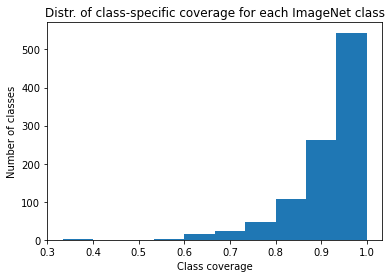

In [149]:
# ======== CLASS-BALANCED CONFORMAL INFERENCE ======== 
# --- Get confidence sets ---
default_qhat = standard_ci_qhat
qhats = compute_class_specific_qhats(calib_logits, calib_labels, alpha=alpha, default_qhat=default_qhat)
print('qhats:', qhats)
class_balanced_ci_preds = create_cb_prediction_sets(val_logits, qhats)

# --- Evaluate confidence sets ---
# i) Marginal coverage
cb_marginal_cov = compute_coverage(val_labels, class_balanced_ci_preds)
print(f'Class-balanced conformal inference "marginal coverage": {cb_marginal_cov*100:.2f}%')
# ii) Class-specific coverage
cb_class_specific_cov = compute_class_specific_coverage(val_labels, class_balanced_ci_preds)
# print(f'Standard conformal inference "class specific coverage": {class_specific_cov}')
plt.hist(cb_class_specific_cov)
plt.xlabel('Class coverage')
plt.ylabel('Number of classes')
plt.title('Distr. of class-specific coverage for each ImageNet class')
plt.show()

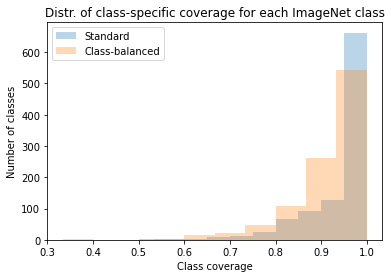

In [150]:
# Combine histograms into one plot

plt.hist(class_specific_cov, label="Standard", alpha=.3)
plt.hist(cb_class_specific_cov, label="Class-balanced", alpha=.3)
plt.xlabel('Class coverage')
plt.ylabel('Number of classes')
plt.title('Distr. of class-specific coverage for each ImageNet class')
plt.legend()
plt.show()

In [140]:
class_balanced_ci_preds

[array([126, 314, 328, 396]),
 array([341, 344, 467, 633]),
 array([ 16,  20,  91, 596, 633]),
 array([203, 459, 470, 596, 633, 731, 837]),
 array([151, 227, 237]),
 array([401, 402, 420, 541, 542, 546, 632, 641, 643, 650, 776, 787, 818,
        819, 854]),
 array([162, 539, 811, 906]),
 array([438, 469, 504, 505, 521, 550, 556, 567, 618, 633, 647, 651, 686,
        811, 813, 827, 828, 859, 891, 909, 966, 967, 968]),
 array([534, 539, 556, 651, 731, 740, 747, 784, 799, 811, 827, 830, 882]),
 array([413, 473, 477, 488, 499, 584, 587, 589, 596, 597, 600, 623, 633,
        686, 740, 758, 763, 764, 777, 784, 787, 792, 798, 818]),
 array([314, 365, 371, 381, 459, 633, 835]),
 array([432, 523, 542, 558, 596, 633, 683, 696, 752, 764, 767, 776, 784,
        798, 823, 875, 906, 918]),
 array([339, 514, 515, 603, 676, 787, 808, 912]),
 array([347, 354]),
 array([165, 234, 236, 811, 837]),
 array([417, 438, 572, 618, 633, 712, 723, 818, 837, 898, 966, 971]),
 array([400, 419, 423, 424, 438, 459, 

In [141]:
standard_ci_preds

[array([328, 396]),
 array([341, 342, 343, 344, 719]),
 array([13, 16, 17, 19, 20, 91]),
 array([184, 192, 199, 202, 203]),
 array([151, 158, 171, 172, 223, 225, 227, 237]),
 array([401, 402, 420, 486, 513, 541, 542, 546, 593, 641, 642, 650, 776,
        818, 819, 875, 889]),
 array([162, 164, 166, 188, 263]),
 array([469, 504, 505, 521, 544, 550, 567, 813, 827, 828, 849, 859, 891,
        967]),
 array([534, 731, 788, 840, 882, 897]),
 array([413, 456, 473, 477, 499, 512, 587, 596, 597, 726, 740, 758, 763,
        764, 777, 784]),
 array([365, 367, 369, 370, 371, 381]),
 array([401, 418, 432, 513, 558, 566, 594, 683, 776, 875]),
 array([339, 515, 603, 676, 912]),
 array([  9, 294, 347, 354, 355]),
 array([165, 214, 234, 236, 237]),
 array([572, 712, 723, 971]),
 array([419, 423, 424, 438, 551, 570, 585, 617, 631, 633, 648, 678, 691,
        712, 720, 823, 838, 845]),
 array([977, 978]),
 array([ 26,  44,  52,  53,  54,  57,  58,  59,  60,  63,  65, 390]),
 array([825]),
 array([ 30,  